# Exercise round 8

## Exercise 1

In [1]:
%matplotlib inline
import numpy as np
import scipy.linalg as linalg
import scipy.integrate as integrate
import math
import matplotlib.pyplot as plt

eta = 0.5
k = 1.0
m = 1.0
tmp = (eta/m)**2 - 4*k/m
print(tmp)

-3.75


In [3]:
t = np.linspace(0,10,100)
A = np.array([[0,1], [-k/m,-eta/m]])
x0 = np.array([1,0])
x = np.zeros((t.shape[0],2))
for i in range(t.shape[0]):
    x[i,:] = linalg.expm(A*t[i])@x0

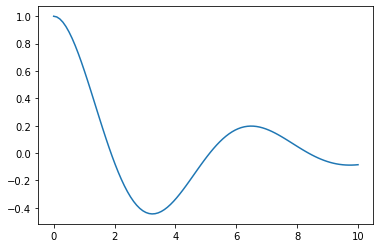

In [4]:
plt.clf()
plt.plot(t,x[:,0])

In [11]:
dt = 0.2
F  = linalg.expm(A*dt)
t2 = np.arange(0,10,dt)
x2 = np.zeros((t2.shape[0],2))
cx = x0
x2[0,:] = cx
for i in range(1,t2.shape[0]):
    cx = F@cx
    x2[i,:] = cx
    

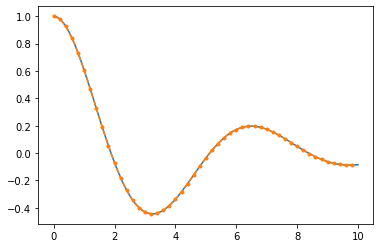

In [12]:
plt.clf()
plt.plot(t,x[:,0],t2,x2[:,0],'--.')

## Exercise 2

In [18]:
%matplotlib inline
import numpy as np
import scipy.linalg as linalg
import scipy.integrate as integrate
import math
import matplotlib.pyplot as plt

dt  = 0.1
s2w = 0.1
F   = np.array([[1,dt],[0,1]])
print(F)

[[1.  0.1]
 [0.  1. ]]


In [19]:
Q = s2w * np.array([[dt**3/3,dt**2/2],[dt**2/2,dt]])
print(Q)

[[3.33333333e-05 5.00000000e-04]
 [5.00000000e-04 1.00000000e-02]]


In [20]:
L = linalg.cholesky(Q, lower=True)

In [21]:
print(L @ L.T)

[[3.33333333e-05 5.00000000e-04]
 [5.00000000e-04 1.00000000e-02]]


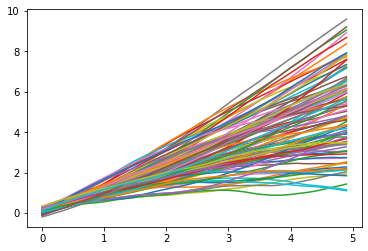

In [32]:
m0 = np.array([0,1])
P0 = 0.01 * np.eye(2)

nmc = 100

t  = np.arange(0,5,dt)
sx = np.zeros((nmc,t.shape[0],2))

plt.clf()
for n in range(nmc):
    L0 = linalg.cholesky(P0, lower=True)
    cx = m0 + L0 @ np.random.normal(size=(m0.shape))
    sx[n,0,:] = cx
    for i in range(t.shape[0]):
        q = L @ np.random.normal(size=cx.shape)
        cx = F @ cx + q
        sx[n,i,:] = cx
    plt.plot(t,sx[n,:,0])

In [33]:
ms1 = np.zeros((t.shape[0],m0.shape[0]))
Ps1 = np.zeros((t.shape[0],P0.shape[0],P0.shape[1]))
ms2 = np.zeros((t.shape[0],m0.shape[0]))
Ps2 = np.zeros((t.shape[0],P0.shape[0],P0.shape[1]))
m = m0
P = P0
for i in range(t.shape[0]):
    ms1[i,:] = np.mean(sx[:,i,:],axis=0)
    ms2[i,:] = m
    Ps1[i,:,:] = np.cov(sx[:,i,:],rowvar=False)
    Ps2[i,:] = P
    m = F @ m
    P = F @ P @ F.T + Q


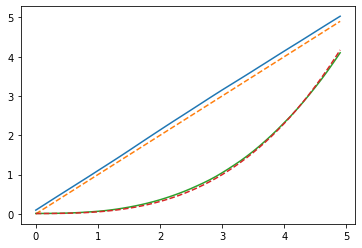

In [34]:
plt.clf()
plt.plot(t,ms1[:,0],t,ms2[:,0],'--')
plt.plot(t,Ps1[:,0,0],t,Ps2[:,0,0],'--')

## Exercise 3

In [36]:
%matplotlib inline
import numpy as np
import scipy.linalg as linalg
import scipy.integrate as integrate
import math
import matplotlib.pyplot as plt

def fr(x,u):
    return np.array([u[0] * np.cos(x[2]), u[0] * np.sin(x[2]), u[1]])

In [37]:
x0 = np.array([0,0,0])
dt = 0.1
tr = np.arange(0,5+dt,dt)    

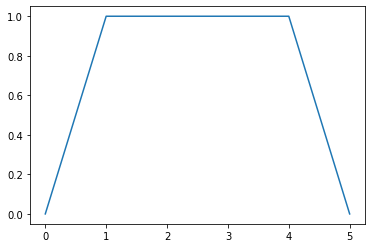

In [38]:
V = np.zeros((tr.shape[0],))
Omega = np.zeros((tr.shape[0],))
for k in range(tr.shape[0]):
    if tr[k] < 1:
        V[k] = tr[k]
    elif tr[k] >= 4:
        V[k] = 5 - tr[k]
    else:
        V[k] = 1
        
    if tr[k] < 2 or tr[k] >= 3:
        Omega[k] = 0
    else:
        Omega[k] = math.pi / 2

plt.clf()
#plt.plot(tr,Omega)
plt.plot(tr,V)

Text(0.5, 1.0, 'Position')

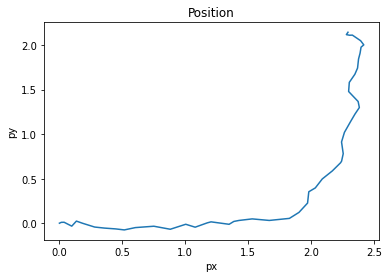

In [40]:
xr_em = np.zeros((tr.shape[0],3))
cx = x0
q1 = 0.01
q2 = 0.01
q3 = 0.01

for k in range(1,tr.shape[0]):
    u  = np.array([V[k-1],Omega[k-1]])
    dt = tr[k] - tr[k-1]
    w  = np.diag(np.sqrt(dt * np.array([q1,q2,q3]))) @ np.random.normal(size=(3,))
    cx = cx + dt * fr(cx,u) + w
    xr_em[k,:] = cx
    
plt.clf()
plt.plot(xr_em[:,0],xr_em[:,1])
plt.xlabel('px')
plt.ylabel('py')
plt.title('Position')

In [41]:
#def fr(x,u):
#    return np.array([u[0] * np.cos(x[2]), u[0] * np.sin(x[2]), u[1]])

def Ar(x,u):
    return np.array([[0,0,-u[0] * np.sin(x[2])], [0,0,u[0]*np.cos(x[2])], [0,0,0]])

In [42]:
# See Simo Särkkä and Arno Solin (2019). Applied Stochastic Differential Equations. Cambridge University Press. 
# http://users.aalto.fi/~ssarkka/pub/sde_book.pdf
# https://github.com/AaltoML/SDE

def lti_disc(A, B, Qc=None, dt=1.0):
    n = A.shape[0]

    if Qc is None:
        Qc = np.eye(n, dtype=A.dtype)
    if np.isscalar(Qc):
        Qc = np.array([[Qc]])

    Phi = np.zeros((2*n,2*n), dtype=A.dtype)
    Phi[ 0:n,  0:n] = A
    Phi[ 0:n,  n: ] = B @ Qc @ B.T
    Phi[n:2*n, n: ] = -A.T

    EPhi = linalg.expm(Phi * dt)
    F = EPhi[0:n, 0:n]
    Q = EPhi[0:n, n:] @ F.T

    return F, Q

# We can form the integral of expm(A t) by considering
#    dx/dt = A x + y
#    dy/dt = 0
def expm_int(A, dt):
    n = A.shape[0]
    tmp = np.zeros((2*n,2*n), dtype=A.dtype)
    tmp[0:n, 0:n] = A
    tmp[0:n, n:]  = np.eye(n)
    tmp_exp = linalg.expm(tmp * dt)
    return tmp_exp[0:n,n:]
   

In [43]:
# Test with the Wiener velocity model:
F,Q = lti_disc(np.array([[0,1],[0,0]]), np.array([[0],[1]]), 1, 0.1)


In [44]:
print(Q)

[[0.00033333 0.005     ]
 [0.005      0.1       ]]


In [45]:
IE = expm_int(np.array([[0,1],[0,0]]), 0.1)
print(IE)
print(F*dt)

[[0.1   0.005]
 [0.    0.1  ]]
[[0.1  0.01]
 [0.   0.1 ]]


Text(0.5, 1.0, 'Position')

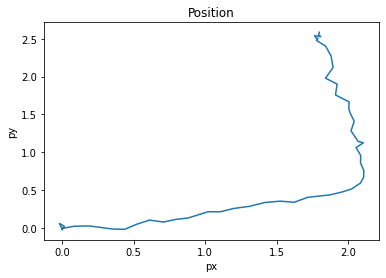

In [46]:
xr_lin = np.zeros((tr.shape[0],3))
cx = x0

for k in range(1,tr.shape[0]):
    u  = np.array([V[k-1],Omega[k-1]])
    dt = tr[k] - tr[k-1]
    IE = expm_int(Ar(cx,u), dt)
    F,Q = lti_disc(Ar(cx,u), np.eye(3), np.diag(np.array([q1,q2,q3])), dt)
    L  = linalg.cholesky(Q, lower=True)
    q  = L @ np.random.normal(size=(3,))
    cx = cx + IE @ fr(cx,u) + q
    xr_lin[k,:] = cx;
    
plt.clf()
plt.plot(xr_lin[:,0],xr_lin[:,1])
plt.xlabel('px')
plt.ylabel('py')
plt.title('Position')